In [1]:
import sys
sys.path.append('../../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_rc,
                   get_parameter_recovery, get_posterior_predictive_check)
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
rng_seed = 123

sns.set()
sns.set_style("white")

device = 'cpu'

sim_type = 'rc_circuit'
data_path = f'../../data/{sim_type}'

with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
zero_samples = posterior_metadata['zero_samples'] 

simulator = partial(simulator_rc, prior_dict=prior_dict, tstop=tstop)

/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


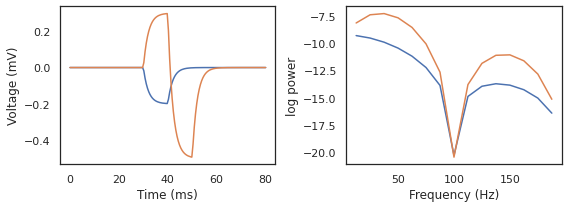

In [2]:
%matplotlib inline
# Values on [0,1] mapped to range of bounds defined in prior_dict
theta_cond_list = [np.array([0.3, 0.5, 0.5]), np.array([0.3, 0.5, 0.75])]

x_cond_list, theta_dict_list = list(), list()
for theta_cond in theta_cond_list:
    theta_dict = {param_name: param_dict['scale_func'](theta_cond[idx], param_dict['bounds']) for 
                  idx, (param_name, param_dict) in enumerate(prior_dict.items())}

    x_cond = simulator(torch.tensor(theta_cond).float())
    x_cond[:, :zero_samples] = np.repeat(x_cond[:, zero_samples], zero_samples).reshape(x_cond.shape[0], zero_samples)
                   
    theta_dict_list.append(theta_dict)
    x_cond_list.append(x_cond.T)

# Plot conditioning features    
t_vec = np.linspace(0, tstop, x_cond_list[0].squeeze().shape[0])
x_cond_psd0, f = get_dataset_psd(x_cond_list[0], posterior_metadata['fs'])
x_cond_psd1, _ = get_dataset_psd(x_cond_list[1], posterior_metadata['fs'])

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(t_vec, x_cond_list[0].squeeze())
plt.plot(t_vec, x_cond_list[1].squeeze())
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.subplot(1,2,2)
plt.plot(f, x_cond_psd0.squeeze())
plt.plot(f, x_cond_psd1.squeeze())
plt.xlabel('Frequency (Hz)')
plt.ylabel('log power')

plt.tight_layout()

#plt.savefig(f'../../../figures/{sim_type}/posterior_compare_cond_{sim_type}.svg')
#plt.close()

Conditioning Feature: pca30


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Conditioning Feature: peak


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Conditioning Feature: psd


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

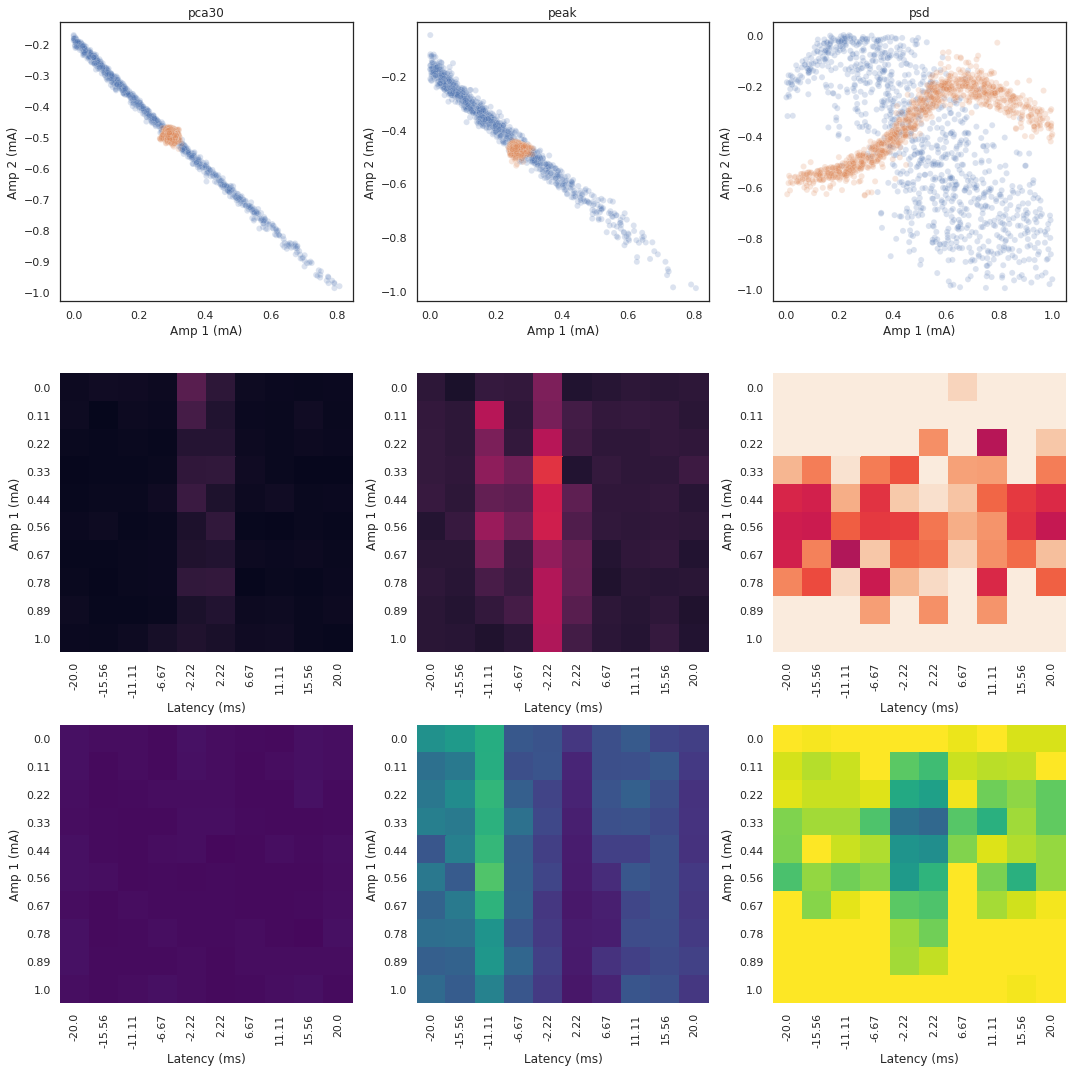

In [9]:
prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

param_labels = ['Amp 1 (mA)', 'Amp 2 (mA)', 'Latency (ms)']

nval_samples = 10

all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]
xticks = np.round(np.linspace(all_bounds[n_params-1][0], all_bounds[n_params-1][1], nval_samples), decimals=2)
yticks = np.round(np.linspace(all_bounds[0][0], all_bounds[0][1], nval_samples), decimals=2)

# x_orig stores full waveform to be used for embedding
x_orig, theta_orig = np.load(f'{data_path}/sbi_sims/x_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
x_grid, theta_grid = np.load(f'{data_path}/sbi_sims/x_grid.npy'), np.load(f'{data_path}/sbi_sims/theta_grid.npy')


# Pick posterior to load
plt.figure(figsize=(15,15))

input_type_list = ['pca30', 'peak', 'psd']
for plot_idx, input_type in enumerate(input_type_list):
    posterior_dict = posterior_state_dicts[input_type]
    state_dict = posterior_dict['posterior']
    n_params = posterior_dict['n_params']
    n_sims = posterior_dict['n_sims']
    input_dict = posterior_dict['input_dict']

    embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])
    
    # Samples from posterior conditoned on grid sweep sims
    x_val = np.load(f'{data_path}/sbi_sims/x_{input_type}_validation.npy')
    x_val[:, :zero_samples] = np.zeros(x_val[:, :zero_samples].shape)

    theta_val = np.load(f'{data_path}/sbi_sims/theta_{input_type}_validation.npy')


    print(f'Conditioning Feature: {input_type}')

    # Posterior scatter plot: get samples for conditoning waveform
    num_samples = 1000
    all_labels = list(prior_dict.keys())
    all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

    df_list, theta_cond_transformed_list = list(), list()
    cond_name = ['Large', 'Small']
    for x_cond, cond_name, theta_cond in zip(x_cond_list, cond_name, theta_cond_list):
        load_info = {name: {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                            'x_cond': posterior_dict['input_dict']['feature_func'](x_cond)}
                     for name, posterior_dict in posterior_state_dicts.items()}
        posterior = load_posterior(state_dict=state_dict,
                                   x_infer=torch.tensor(load_info[input_type]['x_train'][:10,:]).float(),
                                   theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)

        samples = posterior.sample((num_samples,), x=torch.tensor(load_info[input_type]['x_cond'].squeeze()))
        samples_transformed = linear_scale_array(samples.numpy(), all_bounds)

        theta_cond_transformed = linear_scale_array(theta_cond.reshape(1,-1), all_bounds)[0]
        df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}
        df_dict['cond_name'] = np.repeat(cond_name, num_samples)

        df_temp = pd.DataFrame(df_dict)

        theta_cond_transformed_list.append(theta_cond_transformed)
        df_list.append(df_temp)
    df = pd.concat(df_list)
    
    # Posterior scatter plot
    plt.subplot(3,3,1 + plot_idx)
    sns.scatterplot(data=df, x='amp1', y='amp2', hue='cond_name', legend=False, alpha=0.2)
    plt.xlabel('Amp 1 (mA)')
    plt.ylabel('Amp 2 (mA)')
    plt.title(input_type)
    
    # Parameter recovery
    dist_array = get_parameter_recovery(theta_val, theta_grid, n_samples=nval_samples)
    plt.subplot(3,3,4 + plot_idx)
    sns.heatmap(dist_array[:,0].reshape(nval_samples, nval_samples, nval_samples)[:,5,:],
                vmin=0, vmax=0.3, xticklabels=xticks, yticklabels=yticks, cbar=False)
    plt.xlabel(param_labels[2])
    plt.ylabel(param_labels[0])

    # Posterior Predictive Check: RMSE between ground truth sim and posterior samples
    ppc_array = get_posterior_predictive_check(x_val, x_grid, n_samples=nval_samples)
    plt.subplot(3,3,7 + plot_idx)
    sns.heatmap(ppc_array.reshape(nval_samples, nval_samples, nval_samples)[:,5,:],
                vmin=0, vmax=0.2, xticklabels=xticks, yticklabels=yticks, cmap='viridis', cbar=False)
    plt.xlabel(param_labels[2])
    plt.ylabel(param_labels[0])

plt.tight_layout()    

